In [18]:
import logging
import os
import sys
from datetime import datetime
import sys


# Define log file name and path
log_file = f"Digital Claim Adjudicator {datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.log"

#Custome logger
logger = logging.getLogger("LOG")
logger.setLevel(logging.DEBUG)

#Create Handler
c_handler = logging.StreamHandler()

c_handler.setLevel(logging.DEBUG)

#Setting the Format
c_format = logging.Formatter("%(asctime)s - %(name)s - %(module)s - %(levelname)s : %(message)s", datefmt='%Y-%m-%d %H:%M:%S')

c_handler.setFormatter(c_format)

#Add Handler
logger.addHandler(c_handler)


In [2]:
import os
import pickle
import yaml
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score



def replace_null_with_mean(df, num_cols):
    """
    This function replaces null values in the specified numerical columns of a DataFrame with their mean.

    Parameters:
    df (pandas.DataFrame): The DataFrame.
    num_cols (list): The list of numerical columns.

    Returns:
    pandas.DataFrame: The DataFrame with null values replaced.
    """
    for col in num_cols:
        if col in df.columns:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        logger.info("Object saved successfully")
    except Exception as e:
        logger.info("Error in save_objects: {}".format(e))
        
def outlier_removal(df, num_cols):
    for column in num_cols:
        upper_limit = df[column].mean() + 2 * df[column].std()
        lower_limit = df[column].mean() - 2 * df[column].std()
        df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

def fill_empty_with_mode(df, cat_cols):
    for i in cat_cols:
        if (df[i] == '').any():
            mode_value = df[i][df[i]!=""].mode().iloc[0]
            df[i] = df[i].replace('',mode_value )
    return df




def random_search_cv(model, X_train, y_train,params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="r2", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_

#Confusion Matrix

def confusion_matrix_classification_report(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    #Classification Report
    report = classification_report(y_test, y_pred)
    logger.info(report)
    

class FeatureClassifier:
    def __init__(self,df, target_column):
        self.df = df
        self.target_column = target_column
    
    def get_ordinal_columns_mapping(self,columns):
        """
        This function is used to get the mapping of ordinal columns.
        Each key is named as 'ColumnName_Map' and contains the unique values for that column.
        """
        columns_mapping = {}
        
        for col in columns:
            sorted_groups = self.df.groupby(col)[self.target_column].mean().sort_values().index.tolist()
            key_name = f"{col}"
            columns_mapping[key_name] = sorted_groups
        
        return columns_mapping
        

        
    def ordinal_onehot_numerical_divide(self):
        """
        This function is used to divide the categorical into ordinal and one-hot columns and numerical columns.
        """
        one_hot_cols = []
        ordinal_cols = []
        num_cols = []
        #Overall mean
        mean = self.df[self.target_column].mean()
        thereshold_percentage = 0.1
        threshold_value = mean * thereshold_percentage
        try:
            for column in self.df.columns:
                if column != self.target_column and self.df[column].dtype == 'object':
                    df_column = self.df[[column, self.target_column]].groupby(column).mean().reset_index()
                    standard_dev = df_column[self.target_column].std()
                    if standard_dev > threshold_value:
                        ordinal_cols.append(column)
                    else:
                        one_hot_cols.append(column)
                else:
                    num_cols.append(column)
            
            logger.info("ordinal_onehot_numerical_divide done!!!")

            #Get Mappingsd for ordinal columns:
            ordinal_columns_mapping = self.get_ordinal_columns_mapping(ordinal_cols)
            one_hot_column_mapping = self.get_ordinal_columns_mapping(one_hot_cols)
            return (one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
                 

        except Exception as e:
            logger.info(e)

def save_objects(file_path, obj):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(obj, f)
        logger.info("Object saved successfully")
    except Exception as e:
        logger.info("Error in save_objects: {}".format(e))
    

def load_obj(file_path):
    try:
        with open(file_path, 'rb') as f:
            obj = pickle.load(f)
        logger.info("Object loaded successfully")
        return obj
    except Exception as e:
        logger.info("Error in load_obj: {}".format(e))
    
from sklearn.metrics import accuracy_score


def random_search_cv_classification(model, X_train, y_train, params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="accuracy", cv = 5, verbose=0 )
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_


def random_search_cv_regression(model, X_train, y_train, params):
    random_cv = RandomizedSearchCV(model, param_distributions=params, scoring="r2", cv = 5, verbose=0)
    random_cv.fit(X_train, y_train)
    return random_cv, random_cv.best_params_, random_cv.best_score_


def evaluate_model_classification(X_train, y_train, X_test, y_test, models):
    report = {}
    config = {
                "SVC": {
                    "C": [0.1, 1, 10, 100],
                    "kernel": ["linear", "poly", "rbf", "sigmoid"],
                    "degree": [2, 3, 4, 5],
                    "gamma": ["scale", "auto"]
                },
                "DecisionTree": {
                    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,28,29,20],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "RandomForest": {
                    "n_estimators": [50, 100, 150, 200],
                    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,28,29,20],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "GradientBoostingClassification": {
                    "n_estimators": [50, 100, 150, 200],
                    "learning_rate": [0.01, 0.1, 0.2],
                    "max_depth": [2,3,4,5,6,7,8,9,10],
                    "min_samples_split": [2,3,4,5,6,7,8,9,10],
                    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
                },
                "BaggingClassification": {
                    "n_estimators": [10, 50, 100],
                    "max_samples": [0.5, 0.7, 1.0],
                    "max_features": [0.5, 0.7, 1.0],
                    "bootstrap": [True, False],
                    "bootstrap_features": [True, False]
                }
            }

    try:
        
        for i in range(len(models)):
            model = list(models.values())[i]
            model_flag = list(models.keys())[i]
            # model.fit(X_train, y_train)
            
            params = config[model_flag]
            logger.info(f"Currently checking for {model_flag}")
            model, model.best_params_, model.best_score_ = random_search_cv_classification(model, X_train, y_train, params)
            
            y_pred = model.predict(X_test)

            test_model_score = accuracy_score(y_test, y_pred)
            logger.info('\n====================================================================================\n')
            logger.info(f"The confusion matrix and classification report for the model: {model_flag} is:")
            confusion_matrix_classification_report(y_test, y_pred)
            logger.info('\n====================================================================================\n')


            logger.info('\n====================================================================================\n')
            logger.info(f"The best parameters for the model{model_flag} are {model.best_params_}")
            logger.info('\n====================================================================================\n')


            report[list(models.keys())[i]] =  {"score": test_model_score, "best_params": model.best_params_}
            logger.info(f"Model: {list(models.keys())[i]}, Accuracy score: {test_model_score}")
        logger.info("Model evaluation complete")
        return report

    except Exception as e:
        logger.info("Error in evaluate_model: {}".format(e))
        



def evaluate_model_regression(X_train, y_train, X_test, y_test, models):
    report = {}

    try:
        with open(regression_param_path, 'r') as file:  # Ensure correct path to your regression parameters file
            config = yaml.safe_load(file)

        for i in range(len(models)):
            model = list(models.values())[i]
            model_flag = list(models.keys())[i]

            params = config[model_flag]
            model, model.best_params_, model.best_score_ = random_search_cv_regression(model, X_train, y_train, params)

            y_pred = model.predict(X_test)

            test_model_score = r2_score(y_test, y_pred)  # R-squared used as evaluation metric
            logger.info('\n====================================================================================\n')
            logger.info(f"The R-squared and RMSE for the model: {model_flag} are:")
            logger.info(f"R-squared: {test_model_score}")  # Reporting RMSE along with R-squared
            logger.info('\n====================================================================================\n')

            logger.info('\n====================================================================================\n')
            logger.info(f"The best parameters for the model {model_flag} are {model.best_params_}")
            logger.info('\n====================================================================================\n')

            report[list(models.keys())[i]] = {"score": test_model_score, "best_params": model.best_params_}
            logger.info(f"Model: {list(models.keys())[i]}, R-squared: {test_model_score}")
        logger.info("Model evaluation complete")
        return report

    except Exception as e:
        logger.info("Error in evaluate_model: {}".format(e))
        raise e

In [3]:
import os # We use os to create path...
import sys
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # Ordinal Encoding for categorical variables
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer #Group everything together
from dataclasses import dataclass
import json


class DataTransformation:
    
    def __init__(self):
        pass
    

    def get_data_transformation_object(self, categories, one_hot_cols, ordinal_cols, num_cols, binary_cols, target):
        
        try:
            # Independent numerical columns
            num_cols_list = [num for num in num_cols if num != target]  ##It can be automated via taking from UI

            # Define pipelines for categorical and numeric data
            # Define pipeline for binary columns
            binary_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent'))
            ])

            categorical_onehot_pipeline = Pipeline([
                
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder()),
#                 ('scaler', StandardScaler(with_mean=False))
            ])

            categorical_ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OrdinalEncoder(categories=categories)),
#                 ('scaler', StandardScaler(with_mean=False))
            ])

            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])

            # Combine pipelines in a ColumnTransformer
            preprocessor = ColumnTransformer(transformers=[
                ('binary', binary_pipeline, binary_cols),
                ('cat_one_hot', categorical_onehot_pipeline, one_hot_cols),
                ('cat_ordinal', categorical_ordinal_pipeline, ordinal_cols),
                ('num', numerical_pipeline, num_cols_list)
            ])

            logger.info("Pipeline methods creation ends!!!")
            return preprocessor
        
        except Exception as e:
            logger.error("Error in get_data_transformation_object")
            raise e
            
    def inititate_data_transformation(self, df_train, df_test, target, features_to_exclude, user_transformation_name=None):
        try:
            
            logger.info("Initiating data transformation process...")
                
            
            df_train.drop(labels=features_to_exclude, axis=1, inplace=True)
            df_test.drop(labels=features_to_exclude, axis=1, inplace=True)
            logger.info("Features excluded successfully")
            
            # For numerical columns
            for col in df_train.select_dtypes(include=[np.number]).columns:
                df_train[col] = df_train[col].fillna(df_train[col].mean())
            logger.info("Replaced Null with mean for input numerical variables")

            # For non-numerical columns
            for col in df_train.select_dtypes(exclude=[np.number]).columns:
                df_train[col] = df_train[col].fillna(df_train[col].mode().iloc[0])
            logger.info("Replaced Null with mean for input categorical variables")
            
            # Binary columns:
            binary_cols = [col for col in df_train.columns if df_train[col].dtype != 'object' and col != target and df_train[col].nunique() == 2]

            # Number columns:
            num_cols = [col for col in df_train.columns if df_train[col].dtype != 'object' and col != target and col not in binary_cols]

            # Categorical Column:
            cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object' and col != target]


            logger.info("Number columns identified successfully")
        
            
#             #Replacing NA with mean
#             df_train = replace_null_with_mean(df_train, num_cols)
#             df_test = replace_null_with_mean(df_test, num_cols)
#             logger.info("Replaced Null with mean for input numerical variables")
#             logger.info(df_train.shape)
#             logger.info(df_test.shape)
            
#             ##Replacing NA with mean for Target Variable:
#             df_train = replace_null_with_mean(df_train, [target])
#             df_test = replace_null_with_mean(df_test, [target])            
#             logger.info("Replaced Null with mean for Target Variable")
            
#             #Fill empty feature with mode
#             df_train = fill_empty_with_mode(df_train,cat_cols)
#             logger.info("Empty values filled with mode successfully")

#             df_test = fill_empty_with_mode(df_test,cat_cols)
#             logger.info("Empty values filled with mode successfully")
            
            
            # Calling Feature Classifier for training data:
            feature_classifier_obj = FeatureClassifier(df_train,target)
            one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping = feature_classifier_obj.ordinal_onehot_numerical_divide()
            logger.info("Categorical columns (one hot, ordinal mapping)  and numerical columns divided successfully")

            # Binary columns:
            binary_cols = [col for col in df_train.columns if df_train[col].dtype != 'object' and col != target and df_train[col].nunique() == 2]

            # Number columns:
            num_cols = [col for col in df_train.columns if df_train[col].dtype != 'object' and col != target and col not in binary_cols]

            # Categorical Column:
            cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object' and col != target]


            
            logger.info(one_hot_cols, ordinal_cols, num_cols, ordinal_columns_mapping, one_hot_column_mapping)
            # Listing all the categories:
            categories = []
            for key, value in ordinal_columns_mapping.items():
                categories.append(value)
            logger.info("Categories created successfully!!!")
            

            preprocessor_obj = self.get_data_transformation_object(categories, one_hot_cols, ordinal_cols, num_cols, binary_cols, target)
            
            # Segregation of input and target feature:

            
            X_train = df_train.drop(labels=target, axis=1)
            y_train = df_train[target]

            X_test = df_test.drop(labels=target, axis=1)
            y_test = df_test[target]

            logger.info("Input and target feature segregated successfully!!!")
        

            # #Transformation using preprocessing object:
            X_train_arr = preprocessor_obj.fit_transform(X_train)
            logger.info(X_train_arr)
            # Convert the array back into a dataframe
            X_train_df = pd.DataFrame(X_train_arr, columns=preprocessor_obj.get_feature_names_out())

            logger.info(X_train_df)

            X_test_arr = preprocessor_obj.transform(X_test)
            # Convert the array back into a dataframe
            X_test_df = pd.DataFrame(X_test_arr, columns=preprocessor_obj.get_feature_names_out())
            logger.info("Preprocessing done successfully!!!")

            train_arr = np.c_[X_train_arr, np.array(y_train)]
            test_arr = np.c_[X_test_arr, np.array(y_test)]

            logger.info("Data transformation done successfully!!!")

 
            logger.info("ordinal_columns_mapping.json created successfully!!!")
            
  
            return train_arr, test_arr, X_train_df, X_test_df
        except Exception as e:
            logger.error("Error occured while initiating the data transformation process: {}".format(e))
            raise e


            

In [4]:
from project_lib import Project
project = Project()
claim_data = project.get_file('Medical_insurance_fraud_balanced_sample.csv')


In [5]:
import pandas as pd
# Convert BytesIO object to pandas DataFrame
df = pd.read_csv(claim_data)
df

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,Gender,Race,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,...,4Avg_DeductibleAmtPaid,4Avg_IPAnnualReimbursementAmt,4Avg_IPAnnualDeductibleAmt,4Avg_OPAnnualReimbursementAmt,4Avg_OPAnnualDeductibleAmt,4Avg_AdmitForDays,ClmCount_Provider,BeneID,AttendingPhysician,PotentialFraud
0,PRV52014,0,0,0,1,1,0,12,12,1,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,351,1,6,0
1,PRV52029,10,0,0,2,1,1,12,12,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,168,1,4,0
2,PRV52025,30,0,0,1,1,0,12,12,1,...,248.656117,7183.76435,862.961933,2158.459215,603.123867,6.081841,119,1,8,0
3,PRV51347,100,0,0,2,1,0,12,9,1,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2067,2,528,1
4,PRV52021,60,60,0,1,1,0,12,12,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,613,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,PRV51488,100,100,0,1,1,0,12,12,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,272,1,4,0
49996,PRV51855,80,0,0,2,1,0,12,12,0,...,631.983333,20926.50000,1950.066667,6193.916667,1646.166667,12.309859,120,1,23,0
49997,PRV51836,50,70,0,2,1,0,12,12,1,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1794,10,924,1
49998,PRV51369,200,0,0,2,3,0,12,12,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2083,4,1005,1


In [6]:
df["PotentialFraud"].value_counts()

0    25000
1    25000
Name: PotentialFraud, dtype: int64

In [7]:
#Split the dataframe into df_train and df_test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
#Give the target variable and the input features to be excluded

target = "PotentialFraud"  #List the target variable
features_to_exclude = ["Provider"] #List the input features to exclude

data_transformation_obj = DataTransformation()
train_arr, test_arr, train_df, test_df = data_transformation_obj.inititate_data_transformation(df_train, df_test, target, features_to_exclude)

2024-05-28 09:42:00 - LOG - 2004334507 - INFO : Initiating data transformation process...
2024-05-28 09:42:00 - LOG - 2004334507 - INFO : Features excluded successfully
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Replaced Null with mean for input numerical variables
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Replaced Null with mean for input categorical variables
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Number columns identified successfully
2024-05-28 09:42:01 - LOG - 2955872519 - INFO : ordinal_onehot_numerical_divide done!!!
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Categorical columns (one hot, ordinal mapping)  and numerical columns divided successfully
--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/envs/Python-RT23.1-Premium/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/envs/Python-RT23.1-Premium/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.form

2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Pipeline methods creation ends!!!
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Input and target feature segregated successfully!!!
/opt/conda/envs/Python-RT23.1-Premium/lib/python3.10/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : [[ 2.          0.          0.         ...  1.27894423  3.42083777
   0.49382292]
 [ 1.          0.          0.         ... -0.63953208 -0.62246673
  -0.66002741]
 [ 1.          0.          0.         ...  0.12794531 -0.62246673
   1.582

2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Preprocessing done successfully!!!
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : Data transformation done successfully!!!
2024-05-28 09:42:01 - LOG - 2004334507 - INFO : ordinal_columns_mapping.json created successfully!!!


In [9]:
import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
import json
from dataclasses import dataclass
import yaml


class InitiateModelTraining:

    def initiate_model_training(self, train_array, test_array, user_model_name = None):
        """
        This function is used to initiate the model training process.
        """
        logger.info("Initiating model training process...")
        try:
            X_train, y_train, X_test, y_test = (
                train_array[:,:-1],
                train_array[:,-1],
                test_array[:,:-1],
                test_array[:,-1]
                )

            models = {
#                 "SVC": SVC(),
                "DecisionTree": DecisionTreeClassifier(random_state=42),
                "RandomForest": RandomForestClassifier(random_state=42),
                #"GradientBoostingClassification": GradientBoostingClassifier(random_state=42),
                #"BaggingClassification" : BaggingClassifier(random_state=42)
            }
            
            model_report: dict = evaluate_model_classification(X_train, y_train, X_test, y_test, models=models)

            logger.info('\n====================================================================================\n')
            logger.info(f'Model Report : {model_report}')
            logger.info('\n====================================================================================\n')

            # Get the model names and their scores
            model_scores = {model_name: model_info['score'] for model_name, model_info in model_report.items()}

            # Find the model with the best score
            best_model_name = max(model_scores, key=model_scores.get)
            best_model_score = model_scores[best_model_name]

            # Get the best parameters for the best model
            best_model_params = model_report[best_model_name]['best_params']
            best_model = models[best_model_name]
            
            # Create a new instance of the model using the best parameters
            best_model = models[best_model_name].set_params(**best_model_params)

            # Fit the model with the best parameters
            best_model.fit(X_train, y_train)
            
            logger.info(f"Model Name is:{best_model_name} and the best parameters are:{best_model_params}, with score {best_model_score}")
            return best_model_name, best_model_params

        except Exception as e:
            logger.error("Error initiating model training process", e)
            raise e


2024-05-28 07:08:52 - LOG - 69236858 - INFO : Initiating model training process...
2024-05-28 07:08:52 - LOG - 2955872519 - INFO : Currently checking for DecisionTree
2024-05-28 07:09:19 - LOG - 2955872519 - INFO : 

2024-05-28 07:09:19 - LOG - 2955872519 - INFO : The confusion matrix and classification report for the model: DecisionTree is:
2024-05-28 07:09:19 - LOG - 2955872519 - INFO :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5049
         1.0       1.00      1.00      1.00      4951

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

2024-05-28 07:09:19 - LOG - 2955872519 - INFO : 

2024-05-28 07:09:19 - LOG - 2955872519 - INFO : 

2024-05-28 07:09:19 - LOG - 2955872519 - INFO : The best parameters for the modelDecisionTree are {'min_samples_split': 9, 'min_samples_leaf': 1, 'max_depth': 16}
2024-05-28 07:09:1

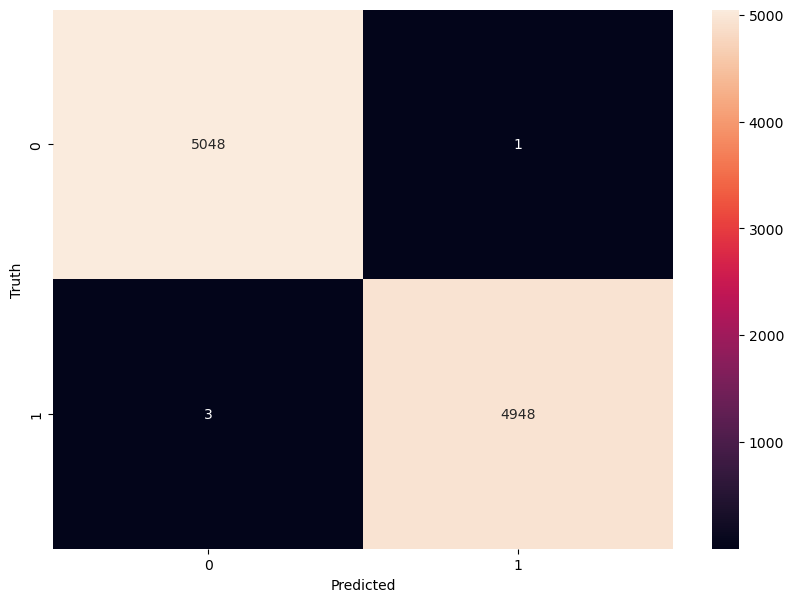

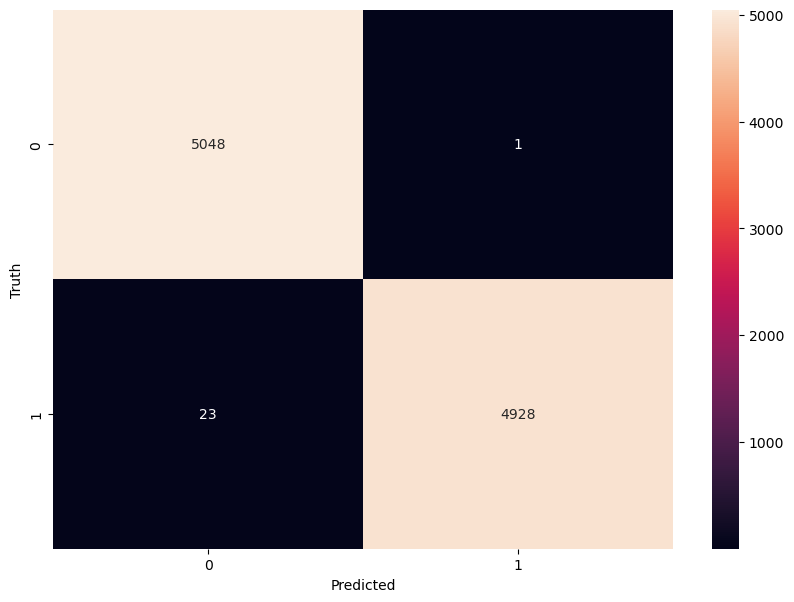

In [10]:
model_trainer_obj = InitiateModelTraining()
best_model_name, best_model_params =  model_trainer_obj.initiate_model_training(train_arr, test_arr, "digital claim")

In [10]:
X_train, y_train, X_test, y_test = (
                train_arr[:,:-1],
                train_arr[:,-1],
                test_arr[:,:-1],
                test_arr[:,-1]
                )


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters
best_param = {'min_samples_split': 9, 'min_samples_leaf': 1, 'max_depth': 16}

# Initialize the RandomForestClassifier with the best parameters
clf_model = DecisionTreeClassifier(
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             max_depth=best_param['max_depth'])
model = clf_model.fit(train_df, y_train)
y_pred = model.predict(test_df)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
test_model_score = accuracy_score(y_test, y_pred)
test_model_score

0.9994

In [19]:
train_df["action_taken_final"] = y_train
train_df["action_taken_final"].value_counts()

1.0    20049
0.0    19951
Name: action_taken_final, dtype: int64

2024-05-28 09:42:23 - LOG - 2955872519 - INFO :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5049
         1.0       1.00      1.00      1.00      4951

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



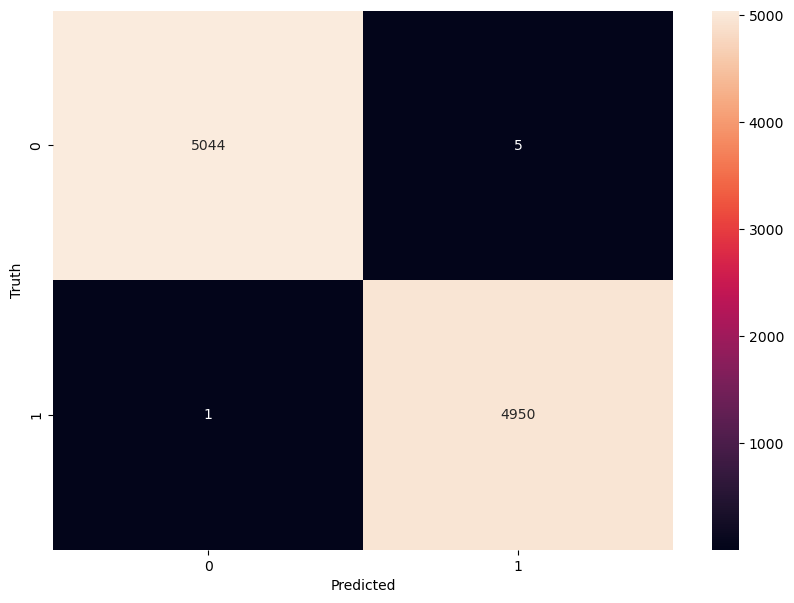

In [13]:
confusion_matrix_classification_report(y_test, y_pred)

In [14]:
import sklearn
print(sklearn.__version__)

1.1.1


In [15]:
model

DecisionTreeClassifier(max_depth=16, min_samples_split=9)

In [16]:
PRE_PROD_SPACE_NAME = 'Digital Claim Adjudicator DT'
PRE_PROD_CHALLENGER_MODEL_NAME="digital_claim_authenticator_dt_sklearn"
PRE_PROD_CHALLENGER_DEPLOYMENT_NAME="Digital Claim Authenticator DT"

In [17]:
import os
import sklearn
from ibm_watson_machine_learning import APIClient
# "url": 'https://cpd-cpd.watsonxgov-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud',

sklearn.__version__
WOS_CREDENTIALS = {
      "url": 'https://cpd-deloittegov485.wxgov485-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud',
      "username": "admin",
      "password": "jUvGt5AugW0T"
  }
WOS_GUID="00000000-0000-0000-0000-000000000000"
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='4.7' #If your env is CP4D 4.x.x then specify "4.x.x" instead of "4.7"
WML_CREDENTIALS

wml_client = APIClient(WML_CREDENTIALS)
print(wml_client.service_instance.get_url())

# Remove existing model and deployment
# PRE_PROD_SPACE_NAME = 'Mortgage Baseline RF_1'
# PRE_PROD_CHALLENGER_MODEL_NAME="mortgage_baseline_rf_sklearn_1"
# PRE_PROD_CHALLENGER_DEPLOYMENT_NAME="Mortgage Baseline RF_1"
MODEL_NAME=PRE_PROD_CHALLENGER_MODEL_NAME
DEPLOYMENT_NAME=PRE_PROD_CHALLENGER_DEPLOYMENT_NAME

wml_client.set.default_project('b0d2a9d6-ffb1-437a-aaa4-7c4a09295132')  # provide the project ID
wml_client.repository.list_models()

# Store Model
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-23.1-py3.10")
model_props_gbt = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1"
}
published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props_gbt, training_data=train_df,training_target=y_train)
print(published_model_details)
##############################################################################################
# List models in the repository
wml_client.repository.list_models()
# Get the model UID
challenger_model_uid = wml_client.repository.get_model_id(published_model_details)
print('challenger_model_uid ', challenger_model_uid)
# print(f'Service Provider ID: {wos_client.service_providers.show()}')

/opt/conda/envs/Python-RT23.1-Premium/lib/python3.10/site-packages/ibm_watson_machine_learning/client.py:184: UserWarning: The provided version: 4.7 is different from the current CP4D version: 4.8. Correct the wml_credentials with proper CP4D version number.
  warn(


https://cpd-deloittegov485.wxgov485-fff3dc4eb79e8bb9c13aa1f85391fe02-0000.us-south.containers.appdomain.cloud
--  ----  -------  ----  ----------  ----------------
ID  NAME  CREATED  TYPE  SPEC_STATE  SPEC_REPLACEMENT
--  ----  -------  ----  ----------  ----------------
{'entity': {'hybrid_pipeline_software_specs': [], 'label_column': 'l1', 'schemas': {'input': [{'fields': [{'name': 'binary__Gender', 'type': 'float64'}, {'name': 'binary__RenalDiseaseIndicator', 'type': 'float64'}, {'name': 'binary__ChronicCond_Alzheimer', 'type': 'float64'}, {'name': 'binary__ChronicCond_Heartfailure', 'type': 'float64'}, {'name': 'binary__ChronicCond_KidneyDisease', 'type': 'float64'}, {'name': 'binary__ChronicCond_Cancer', 'type': 'float64'}, {'name': 'binary__ChronicCond_ObstrPulmonary', 'type': 'float64'}, {'name': 'binary__ChronicCond_Depression', 'type': 'float64'}, {'name': 'binary__ChronicCond_Diabetes', 'type': 'float64'}, {'name': 'binary__ChronicCond_IschemicHeart', 'type': 'float64'}, {'na

------------------------------------  --------------------------------------  ------------------------  ----------------  ----------  ----------------
ID                                    NAME                                    CREATED                   TYPE              SPEC_STATE  SPEC_REPLACEMENT
5682b39a-212c-45ed-9c09-3e84468fbe6d  digital_claim_authenticator_dt_sklearn  2024-05-28T09:42:47.002Z  scikit-learn_1.1  supported
------------------------------------  --------------------------------------  ------------------------  ----------------  ----------  ----------------
challenger_model_uid  5682b39a-212c-45ed-9c09-3e84468fbe6d


In [23]:
wml_client.spaces.list()
# PRE_PROD_SPACE_NAME = 'Mortgage Baseline RF_1'
# PRE_PROD_CHALLENGER_MODEL_NAME="mortgage_baseline_rf_sklearn_1"
# PRE_PROD_CHALLENGER_DEPLOYMENT_NAME="Mortgage Baseline RF_1"
MODEL_NAME=PRE_PROD_CHALLENGER_MODEL_NAME
DEPLOYMENT_NAME=PRE_PROD_CHALLENGER_DEPLOYMENT_NAME
# Find and set the default space
space_name=PRE_PROD_SPACE_NAME
spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in spaces:
    if space['entity']['name'] == space_name:
        space_id = space["metadata"]["id"]
        print(space_id)
if space_id is None:
    space_id = wml_client.spaces.store(
        meta_props={wml_client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["id"]
 
# wml_client.set.default_project('dd59ded6-fd9f-4767-b33d-a3b3a84c0deb')
wml_client.set.default_space(space_id)
 
 
 
# Remove existing model and deployment
MODEL_NAME=PRE_PROD_CHALLENGER_MODEL_NAME
DEPLOYMENT_NAME=PRE_PROD_CHALLENGER_DEPLOYMENT_NAME
# wml_client.set.default_project('dd59ded6-fd9f-4767-b33d-a3b3a84c0deb')
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = wml_client.deployments.get_id(deployment)
    model_id = deployment['entity']['asset']['id']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()
 
# Store Model
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-23.1-py3.10")
model_props_gbt = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.DESCRIPTION: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1"
}
 
published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props_gbt, training_data=train_df,training_target=y_train)
print(published_model_details)
 
# Get the model UID
challenger_model_uid = wml_client.repository.get_model_id(published_model_details)
# Deploy model
wml_deployments = wml_client.deployments.get_details()
challenger_deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        challenger_deployment_uid = wml_client.deployments.get_id(deployment)
        break
 
if challenger_deployment_uid is None:
    print("Deploying model...")
    meta_props = {
        wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.DESCRIPTION: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    deployment = wml_client.deployments.create(artifact_uid=challenger_model_uid, meta_props=meta_props)
    challenger_deployment_uid = wml_client.deployments.get_id(deployment)
 
print("Model id: {}".format(challenger_model_uid))
print("Deployment id: {}".format(challenger_deployment_uid))
 
challenger_deployment_uid=wml_client.deployments.get_id(deployment)
challenger_deployment_uid

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------------------  ------------------------
ID                                    NAME                           CREATED
2c2411cb-5b76-43fa-8890-a0e795c4abaa  Digital Claims Adjustor Space  2024-05-24T07:04:23.944Z
------------------------------------  -----------------------------  ------------------------
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().
Unsetting the project_id ...
--  ----  -------  ----  ----------  ----------------
ID  NAME  CREATED  TYPE  SPEC_STATE  SPEC_REPLACEMENT
--  ----  -------  ----  ----------  ---------



#######################################################################################

Synchronous deployment creation for uid: '9bae3a0e-dfd3-4473-832d-ece0957c0ff6' started

#######################################################################################


initializing
Note: Software specification runtime-22.2-py3.10 is deprecated. Use supported software specification and corresponding model type instead when saving a model and deploy. For details, see https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_latest/wsj/wmls/wmls-deploy-python-types.html.
...........
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d3ed3ca0-e501-4a42-a0d6-b7ff9019c3c5'
------------------------------------------------------------------------------------------------


Model id: 9bae3a0e-dfd3-4473-832d-ece0957c0ff6
Deployment id: d3ed3ca0-e501-4a42-a0d6-b7ff9019c3c5


'd3ed3ca0-e501-4a42-a0d6-b7ff9019c3c5'

In [26]:
train_df

,binary__Gender,binary__RenalDiseaseIndicator,binary__ChronicCond_Alzheimer,binary__ChronicCond_Heartfailure,binary__ChronicCond_KidneyDisease,binary__ChronicCond_Cancer,binary__ChronicCond_ObstrPulmonary,binary__ChronicCond_Depression,binary__ChronicCond_Diabetes,binary__ChronicCond_IschemicHeart,...,num__ClmCount_Provider_ClmDiagnosisCode_9,num__ClmCount_Provider_DiagnosisGroupCode,num__ClmCount_Provider_BeneID_AttendingPhysician,num__ClmCount_Provider_BeneID_OtherPhysician,num__ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,num__ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,num__ClmCount_Provider_BeneID_OperatingPhysician,num__ClmCount_Provider_BeneID_ClmProcedureCode_1,num__ClmCount_Provider_BeneID_ClmDiagnosisCode_1,num__ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.221033,-0.269223,-0.381460,0.662151,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.221033,-0.269223,0.569829,-0.598833,-0.220844,0.122358,1.656885,-0.221248,0.060623,-0.221460
2,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,-0.221033,-0.269223,-0.381460,0.662151,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.643218,2.439907,-0.381460,-0.598833,4.487924,0.122358,1.656885,4.479852,0.060623,4.492905
4,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.221033,-0.269223,-0.381460,-0.598833,-0.220844,0.122358,1.656885,-0.221248,0.060623,-0.221460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.221033,-0.269223,-0.381460,0.662151,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
79995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.221033,-0.269223,-0.381460,-0.598833,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
79996,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.221033,-0.269223,-0.381460,0.662151,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
79997,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.221033,-0.269223,-0.381460,0.662151,-0.220844,0.122358,-0.486778,-0.221248,0.060623,-0.221460
